In [28]:
import os
import random


import cv2 as cv
import tensorflow as tf
from tensorflow.keras import models, layers, optimizers, callbacks, losses
from tensorflow.keras.applications import EfficientNetB4
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np

In [29]:
# Finding the number of images in each dataset
test_path = os.path.normpath('dataset/MapAI/512x512_task1_test/image')
no_test_images = len([name for name in os.listdir(test_path) if os.path.isfile(os.path.join(test_path, name))])

# Defining size of images
IMG_HEIGHT = 512
IMG_WIDTH = 512

# Creating NumPy arrays for the different subsets
X_test = np.zeros((no_test_images, IMG_HEIGHT, IMG_WIDTH, 3), dtype=np.uint8)
Y_test = np.zeros((no_test_images, IMG_HEIGHT, IMG_WIDTH), dtype=np.uint8)

# Adding images to NumPy arrays
img_path = os.path.normpath('dataset/MapAI/512x512_task1_test/image')
mask_path = os.path.normpath('dataset/MapAI/512x512_task1_test/mask')
#mask_path = os.path.normpath('dataset/MapAI/512x512_task1_test/edge_mask')
with os.scandir(img_path) as entries:
    for n, entry in enumerate(entries):
        img = cv.imread(os.path.normpath(img_path + '/' + entry.name))
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
        X_test[n] = img
        mask = cv.imread(os.path.normpath(mask_path + '/' + entry.name))
        mask = cv.cvtColor(mask, cv.COLOR_BGR2GRAY)
        Y_test[n] = mask

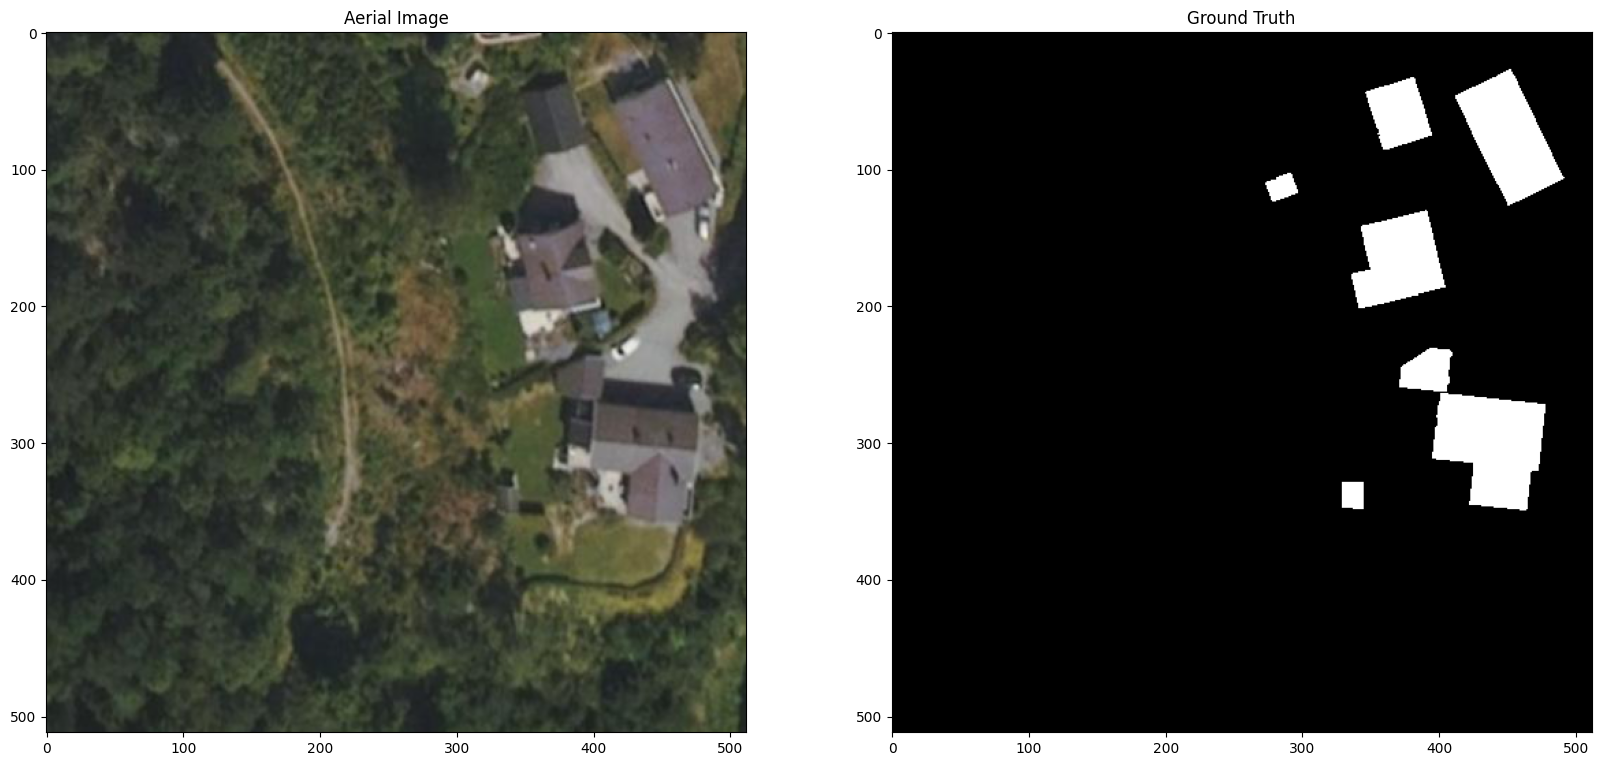

In [34]:
# Display a random image from test set
index = random.randint(0, no_test_images)

plt.figure(figsize=(20,20))
plt.subplot(221)
plt.title('Aerial Image')
plt.imshow(X_test[index])
plt.subplot(222)
plt.title('Ground Truth')
plt.imshow(Y_test[index], cmap='gray')
plt.show()


In [35]:
def _mask_to_boundary(mask, dilation_ratio=0.02):
    """
    Convert binary mask to boundary mask.
    :param mask (numpy array, uint8): binary mask
    :param dilation_ratio (float): ratio to calculate dilation = dilation_ratio * image_diagonal
    :return: boundary mask (numpy array)
    """
    h, w = mask.shape
    img_diag = np.sqrt(h ** 2 + w ** 2)
    dilation = int(round(dilation_ratio * img_diag))
    if dilation < 1:
        dilation = 1
    # Pad image so mask truncated by the image border is also considered as boundary.
    new_mask = cv.copyMakeBorder(mask, 1, 1, 1, 1, cv.BORDER_CONSTANT, value=0)
    kernel = np.ones((3, 3), dtype=np.uint8)
    new_mask_erode = cv.erode(new_mask, kernel, iterations=dilation)
    mask_erode = new_mask_erode[1 : h + 1, 1 : w + 1]
    # G_d intersects G in the paper.
    return mask - mask_erode


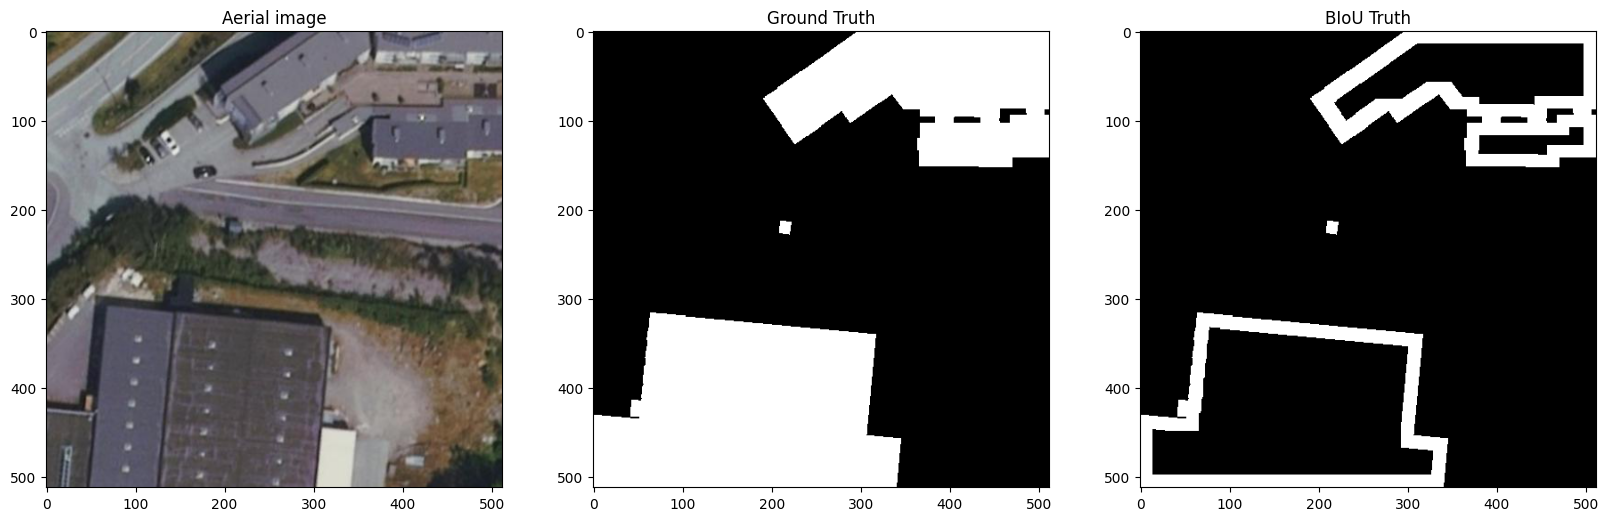

In [45]:
index = random.randint(0, no_test_images)
tempimg = Y_test[index]
tempmask = _mask_to_boundary(tempimg)
plt.figure(figsize=(20,20))
plt.subplot(131)
plt.title('Aerial image')
plt.imshow(X_test[index])
plt.subplot(132)
plt.title('Ground Truth')
plt.imshow(Y_test[index], cmap='gray')
plt.subplot(133)
plt.title('BIoU Truth')
plt.imshow(tempmask, cmap='gray')
plt.show()